# Imports

In [37]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")



# Load datasets

In [38]:
import data_func.read_data as read_data

dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [39]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [40]:
print(len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))


136245
Index([118664], dtype='int64')
136244


In [41]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


# Data clean up

[]
[635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 707, 708, 709, 710, 711, 712, 713, 1348, 1349, 1350, 1351, 1352, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256,

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

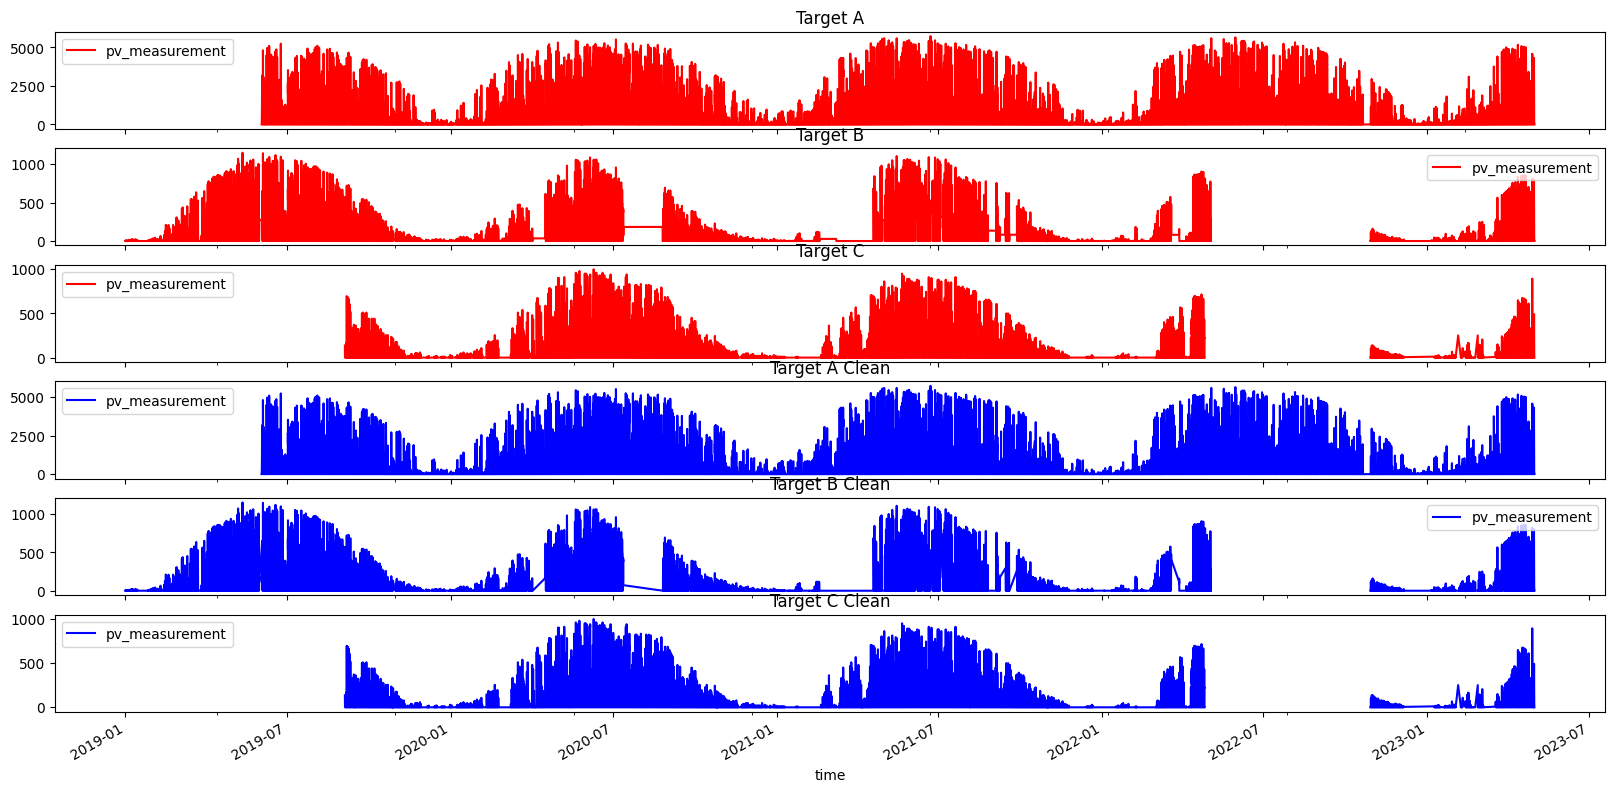

In [42]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



In [43]:
def shift_all_h_columns(df: pd.DataFrame):
    # print length of df before and after
    print("before" + str(len(df)))
    # This functions shifts the given columns by 1.
    columns_to_shift = ['diffuse_rad_1h:J', 'direct_rad_1h:J', 'clear_sky_energy_1h:J', 'fresh_snow_1h:cm']
    for column in columns_to_shift:
        df[column] = df[column].shift(-4)
    
    print("After" + str(len(df)))
    return df
    

In [44]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):
  
  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i] = shift_all_h_columns(X_train[i])
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = shift_all_h_columns(X_frames_test[j])
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


before136244
After136244
before134504
After134504
before134400
After134400
before2880
After2880
before2880
After2880
before2880
After2880


In [45]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34060 34060
x,y:  29596 29596
x,y:  26028 26028


# Feature engineering

In [46]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DF
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DF.date_forecast_columns(X_train[i])

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DF.date_forecast_columns(X_frames_test[i])    
 

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


In [47]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_energy_1h:J']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_energy_1h:J']

    X_train[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_energy_X_eff_cloud_cover'] =  multiply_columns(AT, BT)


# Datacleaning

In [48]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,4588,5122
clear_sky_energy_1h:J,1,1,1
cloud_base_agl:m,2362,2025,2199
diffuse_rad_1h:J,1,1,1
direct_rad_1h:J,1,1,1
fresh_snow_1h:cm,1,1,1
snow_density:kgm3,32920,28040,24561
COMB_clear_sky_energy_X_eff_cloud_cover,1,1,1


In [49]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
clear_sky_energy_1h:J,1,1,1
cloud_base_agl:m,70,65,88
diffuse_rad_1h:J,1,1,1
direct_rad_1h:J,1,1,1
fresh_snow_1h:cm,1,1,1
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [50]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 200000, "cloud_base_agl:m": 200000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [51]:

print(X_train[0]['estimated'])


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
34055    1.0
34056    1.0
34057    1.0
34058    1.0
34059    1.0
Name: estimated, Length: 34060, dtype: float64


In [52]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)





# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)





# Hyperparameter optimization

### Xgboost

In [53]:
# import optuna
# import xgboost as xgb # Change to model to optimize

# # Split the data into training and validation sets
# x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_frames_train[0], Y_frames_train[0], test_size=0.17, random_state=None)
# x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_frames_train[1], Y_frames_train[1], test_size=0.17, random_state=None)
# x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_frames_train[2], Y_frames_train[2], test_size=0.17, random_state=None)


# def objective(trial):
    
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.01, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
#         'random_state': 42,
#     }

#     model = xgb.XGBRegressor(**params) # Change to model to optimize
#     model.fit(x_train_c, y_train_c)

#     # Make predictions on the validation set
#     y_pred = model.predict(x_val_c)

#     # Calculate the Mean Squared Error (MSE) as the metric to optimize
#     mae = mean_absolute_error(y_val_c, y_pred)

#     return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# best = study.best_params
# # Print the best hyperparameters found
# print("Best hyperparameters:", best)



### Catboost

In [54]:
import optuna
import catboost as cat # Change to model to optimize
# Split the data into training and validation sets

# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)


categorical_column = ['dew_or_rime:idx_-1',	'dew_or_rime:idx_0','dew_or_rime:idx_1', 'precip_type_5min:idx_0','precip_type_5min:idx_1','precip_type_5min:idx_2','precip_type_5min:idx_3','precip_type_5min:idx_5', 'is_day:idx', 'is_in_shadow:idx']

def objective(trial):
    
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "cat_features": categorical_column,
        "random_seed": 42,
        "loss_function": "MAE",
        "eval_metric": "MAE",
    }

    model = cat.CatBoostRegressor(**params) # Change to model to optimize
    model.fit(x_train_c, y_train_c)

    # Make predictions on the validation set
    y_pred = model.predict(x_val_c)

    # Calculate the Mean Squared Error (MSE) as the metric to optimize
    mae = mean_absolute_error(y_val_c, y_pred)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best = study.best_params
# Print the best hyperparameters foundc
print("Best hyperparameters:", best)


[I 2023-11-07 11:41:38,706] A new study created in memory with name: no-name-655e4b76-39f9-44f9-bd8d-0e8b8a1e5ca9


0:	learn: 78.3399407	total: 2.69ms	remaining: 2.69s
1:	learn: 78.2355008	total: 5.11ms	remaining: 2.55s
2:	learn: 78.1301291	total: 7.45ms	remaining: 2.48s
3:	learn: 78.0359442	total: 9.87ms	remaining: 2.46s
4:	learn: 77.8942813	total: 12.3ms	remaining: 2.45s
5:	learn: 77.7872099	total: 14.4ms	remaining: 2.39s
6:	learn: 77.6740010	total: 16.5ms	remaining: 2.35s
7:	learn: 77.5683568	total: 18.6ms	remaining: 2.31s
8:	learn: 77.4632657	total: 20.7ms	remaining: 2.27s
9:	learn: 77.3743169	total: 22.8ms	remaining: 2.26s
10:	learn: 77.2597263	total: 24.9ms	remaining: 2.24s
11:	learn: 77.1465839	total: 26.9ms	remaining: 2.22s
12:	learn: 77.0526527	total: 28.9ms	remaining: 2.19s
13:	learn: 76.9436635	total: 30.9ms	remaining: 2.17s
14:	learn: 76.8271282	total: 32.6ms	remaining: 2.14s
15:	learn: 76.7234899	total: 34.4ms	remaining: 2.12s
16:	learn: 76.6108973	total: 36.3ms	remaining: 2.1s
17:	learn: 76.5114250	total: 38.1ms	remaining: 2.08s
18:	learn: 76.4031942	total: 40.1ms	remaining: 2.07s
19:	

[I 2023-11-07 11:41:40,630] Trial 0 finished with value: 27.69608760331207 and parameters: {'learning_rate': 0.002316029047885376, 'depth': 3, 'subsample': 0.7340817936108449, 'colsample_bylevel': 0.24220191341000918, 'min_data_in_leaf': 38}. Best is trial 0 with value: 27.69608760331207.


968:	learn: 29.0799113	total: 1.78s	remaining: 57.1ms
969:	learn: 29.0637660	total: 1.79s	remaining: 55.3ms
970:	learn: 29.0508653	total: 1.79s	remaining: 53.5ms
971:	learn: 29.0373332	total: 1.79s	remaining: 51.6ms
972:	learn: 29.0220932	total: 1.79s	remaining: 49.8ms
973:	learn: 29.0046543	total: 1.79s	remaining: 47.9ms
974:	learn: 28.9898485	total: 1.8s	remaining: 46.1ms
975:	learn: 28.9788524	total: 1.8s	remaining: 44.2ms
976:	learn: 28.9617813	total: 1.8s	remaining: 42.4ms
977:	learn: 28.9474095	total: 1.8s	remaining: 40.5ms
978:	learn: 28.9338304	total: 1.8s	remaining: 38.7ms
979:	learn: 28.9176284	total: 1.8s	remaining: 36.8ms
980:	learn: 28.9015451	total: 1.81s	remaining: 35ms
981:	learn: 28.8865729	total: 1.81s	remaining: 33.1ms
982:	learn: 28.8802950	total: 1.81s	remaining: 31.3ms
983:	learn: 28.8643247	total: 1.81s	remaining: 29.5ms
984:	learn: 28.8475865	total: 1.81s	remaining: 27.6ms
985:	learn: 28.8353321	total: 1.81s	remaining: 25.8ms
986:	learn: 28.8215911	total: 1.82s	

[I 2023-11-07 11:41:42,701] Trial 1 finished with value: 23.323494946686555 and parameters: {'learning_rate': 0.010814470239485814, 'depth': 2, 'subsample': 0.934613893077143, 'colsample_bylevel': 0.9686957230538501, 'min_data_in_leaf': 22}. Best is trial 1 with value: 23.323494946686555.


999:	learn: 22.7265623	total: 1.99s	remaining: 0us
0:	learn: 75.4730824	total: 3.95ms	remaining: 3.94s
1:	learn: 72.2085247	total: 6.89ms	remaining: 3.44s
2:	learn: 69.2800342	total: 9.86ms	remaining: 3.28s
3:	learn: 66.9787766	total: 12.8ms	remaining: 3.2s
4:	learn: 64.3873438	total: 16.1ms	remaining: 3.19s
5:	learn: 62.1524037	total: 20.9ms	remaining: 3.45s
6:	learn: 59.8505674	total: 25.9ms	remaining: 3.67s
7:	learn: 57.9662733	total: 30ms	remaining: 3.72s
8:	learn: 56.3245241	total: 34.2ms	remaining: 3.76s
9:	learn: 54.5103189	total: 37.2ms	remaining: 3.68s
10:	learn: 52.8975996	total: 40.7ms	remaining: 3.66s
11:	learn: 51.1156696	total: 43.9ms	remaining: 3.62s
12:	learn: 49.2315064	total: 47.7ms	remaining: 3.62s
13:	learn: 47.3912211	total: 51.2ms	remaining: 3.61s
14:	learn: 45.8948491	total: 54.5ms	remaining: 3.58s
15:	learn: 44.4740493	total: 58.1ms	remaining: 3.57s
16:	learn: 43.0170026	total: 61.3ms	remaining: 3.54s
17:	learn: 42.1214612	total: 64.3ms	remaining: 3.51s
18:	lear

[I 2023-11-07 11:41:45,365] Trial 2 finished with value: 19.670299795471443 and parameters: {'learning_rate': 0.05575712446404186, 'depth': 6, 'subsample': 0.09184923413445412, 'colsample_bylevel': 0.38888217152591076, 'min_data_in_leaf': 40}. Best is trial 2 with value: 19.670299795471443.


987:	learn: 17.0080189	total: 2.54s	remaining: 30.9ms
988:	learn: 17.0080177	total: 2.54s	remaining: 28.3ms
989:	learn: 17.0045314	total: 2.55s	remaining: 25.7ms
990:	learn: 17.0012533	total: 2.55s	remaining: 23.1ms
991:	learn: 17.0010152	total: 2.55s	remaining: 20.6ms
992:	learn: 16.9934077	total: 2.55s	remaining: 18ms
993:	learn: 16.9933228	total: 2.56s	remaining: 15.4ms
994:	learn: 16.9894063	total: 2.56s	remaining: 12.9ms
995:	learn: 16.9878116	total: 2.56s	remaining: 10.3ms
996:	learn: 16.9869504	total: 2.56s	remaining: 7.71ms
997:	learn: 16.9824643	total: 2.56s	remaining: 5.14ms
998:	learn: 16.9824503	total: 2.57s	remaining: 2.57ms
999:	learn: 16.9818552	total: 2.57s	remaining: 0us
0:	learn: 78.3256476	total: 6.66ms	remaining: 6.65s
1:	learn: 78.1976731	total: 12.1ms	remaining: 6.06s
2:	learn: 78.0449952	total: 18.7ms	remaining: 6.21s
3:	learn: 77.8931287	total: 25ms	remaining: 6.23s
4:	learn: 77.7289100	total: 31.2ms	remaining: 6.2s
5:	learn: 77.5859797	total: 38.4ms	remaining: 

[I 2023-11-07 11:41:51,420] Trial 3 finished with value: 23.33894030516654 and parameters: {'learning_rate': 0.002503598358178931, 'depth': 10, 'subsample': 0.9440937489717302, 'colsample_bylevel': 0.13195234007507733, 'min_data_in_leaf': 49}. Best is trial 2 with value: 19.670299795471443.


993:	learn: 23.5120480	total: 5.87s	remaining: 35.4ms
994:	learn: 23.5046770	total: 5.87s	remaining: 29.5ms
995:	learn: 23.4951670	total: 5.88s	remaining: 23.6ms
996:	learn: 23.4843734	total: 5.88s	remaining: 17.7ms
997:	learn: 23.4730224	total: 5.89s	remaining: 11.8ms
998:	learn: 23.4625828	total: 5.9s	remaining: 5.9ms
999:	learn: 23.4522372	total: 5.9s	remaining: 0us
0:	learn: 76.4477002	total: 3.78ms	remaining: 3.77s
1:	learn: 74.4077069	total: 6.54ms	remaining: 3.27s
2:	learn: 71.8208938	total: 9.02ms	remaining: 3s
3:	learn: 69.4208639	total: 11.9ms	remaining: 2.96s
4:	learn: 67.3620303	total: 14.4ms	remaining: 2.86s
5:	learn: 64.9354841	total: 16.8ms	remaining: 2.78s
6:	learn: 62.7869726	total: 19ms	remaining: 2.7s
7:	learn: 60.7626055	total: 21.4ms	remaining: 2.66s
8:	learn: 58.7655296	total: 23.7ms	remaining: 2.61s
9:	learn: 56.6906963	total: 25.8ms	remaining: 2.55s
10:	learn: 54.9098195	total: 27.9ms	remaining: 2.51s
11:	learn: 53.0986792	total: 30.2ms	remaining: 2.48s
12:	lear

[I 2023-11-07 11:41:53,405] Trial 4 finished with value: 23.150099230534778 and parameters: {'learning_rate': 0.05886303709745514, 'depth': 2, 'subsample': 0.9435017158102239, 'colsample_bylevel': 0.9027966672340585, 'min_data_in_leaf': 48}. Best is trial 2 with value: 19.670299795471443.


981:	learn: 22.5104476	total: 1.87s	remaining: 34.3ms
982:	learn: 22.5104476	total: 1.87s	remaining: 32.4ms
983:	learn: 22.5104476	total: 1.87s	remaining: 30.5ms
984:	learn: 22.5104476	total: 1.88s	remaining: 28.6ms
985:	learn: 22.5104476	total: 1.88s	remaining: 26.7ms
986:	learn: 22.5104476	total: 1.88s	remaining: 24.8ms
987:	learn: 22.5104476	total: 1.88s	remaining: 22.9ms
988:	learn: 22.5104476	total: 1.89s	remaining: 21ms
989:	learn: 22.5104476	total: 1.89s	remaining: 19.1ms
990:	learn: 22.5104476	total: 1.89s	remaining: 17.2ms
991:	learn: 22.5104476	total: 1.89s	remaining: 15.2ms
992:	learn: 22.5104476	total: 1.89s	remaining: 13.3ms
993:	learn: 22.5104476	total: 1.89s	remaining: 11.4ms
994:	learn: 22.5104476	total: 1.9s	remaining: 9.53ms
995:	learn: 22.5104476	total: 1.9s	remaining: 7.62ms
996:	learn: 22.5104476	total: 1.9s	remaining: 5.72ms
997:	learn: 22.5104476	total: 1.9s	remaining: 3.81ms
998:	learn: 22.5104476	total: 1.9s	remaining: 1.91ms
999:	learn: 22.5104476	total: 1.91s

[I 2023-11-07 11:41:55,073] Trial 5 finished with value: 27.46415653601397 and parameters: {'learning_rate': 0.009782898022107973, 'depth': 1, 'subsample': 0.837053973526746, 'colsample_bylevel': 0.5630532938392585, 'min_data_in_leaf': 45}. Best is trial 2 with value: 19.670299795471443.


950:	learn: 27.1590980	total: 1.51s	remaining: 77.7ms
951:	learn: 27.1590980	total: 1.51s	remaining: 76.1ms
952:	learn: 27.1584526	total: 1.51s	remaining: 74.5ms
953:	learn: 27.1584526	total: 1.51s	remaining: 72.9ms
954:	learn: 27.1474901	total: 1.51s	remaining: 71.4ms
955:	learn: 27.1474901	total: 1.52s	remaining: 69.8ms
956:	learn: 27.1474901	total: 1.52s	remaining: 68.2ms
957:	learn: 27.1474901	total: 1.52s	remaining: 66.6ms
958:	learn: 27.1474901	total: 1.52s	remaining: 65ms
959:	learn: 27.1474901	total: 1.52s	remaining: 63.4ms
960:	learn: 27.1474901	total: 1.52s	remaining: 61.8ms
961:	learn: 27.1474901	total: 1.52s	remaining: 60.3ms
962:	learn: 27.1474901	total: 1.53s	remaining: 58.7ms
963:	learn: 27.1470388	total: 1.53s	remaining: 57.1ms
964:	learn: 27.1470388	total: 1.53s	remaining: 55.5ms
965:	learn: 27.1470388	total: 1.53s	remaining: 53.9ms
966:	learn: 27.1470388	total: 1.53s	remaining: 52.3ms
967:	learn: 27.1470388	total: 1.53s	remaining: 50.8ms
968:	learn: 27.1470388	total: 

[I 2023-11-07 11:42:09,103] Trial 6 finished with value: 19.63151222889997 and parameters: {'learning_rate': 0.006575713803645275, 'depth': 9, 'subsample': 0.6028291654664242, 'colsample_bylevel': 0.6993895129568964, 'min_data_in_leaf': 26}. Best is trial 6 with value: 19.63151222889997.


988:	learn: 18.3819232	total: 13.7s	remaining: 152ms
989:	learn: 18.3805921	total: 13.7s	remaining: 138ms
990:	learn: 18.3788638	total: 13.7s	remaining: 125ms
991:	learn: 18.3771130	total: 13.7s	remaining: 111ms
992:	learn: 18.3752505	total: 13.8s	remaining: 96.9ms
993:	learn: 18.3745226	total: 13.8s	remaining: 83.1ms
994:	learn: 18.3725451	total: 13.8s	remaining: 69.2ms
995:	learn: 18.3711180	total: 13.8s	remaining: 55.4ms
996:	learn: 18.3687207	total: 13.8s	remaining: 41.5ms
997:	learn: 18.3662892	total: 13.8s	remaining: 27.7ms
998:	learn: 18.3638082	total: 13.8s	remaining: 13.8ms
999:	learn: 18.3609077	total: 13.8s	remaining: 0us
0:	learn: 76.2610138	total: 3.11ms	remaining: 3.11s
1:	learn: 74.6408488	total: 5.87ms	remaining: 2.93s
2:	learn: 72.2976039	total: 8.29ms	remaining: 2.75s
3:	learn: 70.0173662	total: 10.4ms	remaining: 2.6s
4:	learn: 67.9720584	total: 12.6ms	remaining: 2.5s
5:	learn: 65.7021685	total: 14.8ms	remaining: 2.46s
6:	learn: 63.6618564	total: 17ms	remaining: 2.41s

[I 2023-11-07 11:42:10,864] Trial 7 finished with value: 23.06469773203072 and parameters: {'learning_rate': 0.05427784299655347, 'depth': 2, 'subsample': 0.5434217923359458, 'colsample_bylevel': 0.8178404636844365, 'min_data_in_leaf': 36}. Best is trial 6 with value: 19.63151222889997.


938:	learn: 22.3931544	total: 1.58s	remaining: 103ms
939:	learn: 22.3931544	total: 1.58s	remaining: 101ms
940:	learn: 22.3931543	total: 1.59s	remaining: 99.5ms
941:	learn: 22.3931543	total: 1.59s	remaining: 97.8ms
942:	learn: 22.3931538	total: 1.59s	remaining: 96.1ms
943:	learn: 22.3931538	total: 1.59s	remaining: 94.4ms
944:	learn: 22.3931538	total: 1.59s	remaining: 92.7ms
945:	learn: 22.3931538	total: 1.59s	remaining: 91ms
946:	learn: 22.3931538	total: 1.6s	remaining: 89.3ms
947:	learn: 22.3931538	total: 1.6s	remaining: 87.6ms
948:	learn: 22.3931537	total: 1.6s	remaining: 86ms
949:	learn: 22.3931537	total: 1.6s	remaining: 84.3ms
950:	learn: 22.3931536	total: 1.6s	remaining: 82.6ms
951:	learn: 22.3931536	total: 1.6s	remaining: 80.9ms
952:	learn: 22.3931536	total: 1.61s	remaining: 79.2ms
953:	learn: 22.3931536	total: 1.61s	remaining: 77.5ms
954:	learn: 22.3930935	total: 1.61s	remaining: 75.8ms
955:	learn: 22.3930935	total: 1.61s	remaining: 74.2ms
956:	learn: 22.3930935	total: 1.61s	rema

[I 2023-11-07 11:42:13,101] Trial 8 finished with value: 27.729212853948674 and parameters: {'learning_rate': 0.002276869860579671, 'depth': 3, 'subsample': 0.6528766425899947, 'colsample_bylevel': 0.7087194684054403, 'min_data_in_leaf': 26}. Best is trial 6 with value: 19.63151222889997.


947:	learn: 29.3140902	total: 2.05s	remaining: 112ms
948:	learn: 29.2969142	total: 2.05s	remaining: 110ms
949:	learn: 29.2803560	total: 2.05s	remaining: 108ms
950:	learn: 29.2641867	total: 2.06s	remaining: 106ms
951:	learn: 29.2466658	total: 2.06s	remaining: 104ms
952:	learn: 29.2294519	total: 2.06s	remaining: 102ms
953:	learn: 29.2134151	total: 2.06s	remaining: 99.4ms
954:	learn: 29.1972969	total: 2.06s	remaining: 97.3ms
955:	learn: 29.1800771	total: 2.07s	remaining: 95.1ms
956:	learn: 29.1646898	total: 2.07s	remaining: 92.9ms
957:	learn: 29.1504985	total: 2.07s	remaining: 90.8ms
958:	learn: 29.1333403	total: 2.07s	remaining: 88.6ms
959:	learn: 29.1160385	total: 2.07s	remaining: 86.4ms
960:	learn: 29.1012656	total: 2.08s	remaining: 84.3ms
961:	learn: 29.0851460	total: 2.08s	remaining: 82.1ms
962:	learn: 29.0692205	total: 2.08s	remaining: 79.9ms
963:	learn: 29.0543272	total: 2.08s	remaining: 77.8ms
964:	learn: 29.0393238	total: 2.08s	remaining: 75.6ms
965:	learn: 29.0250343	total: 2.09

[I 2023-11-07 11:42:28,003] Trial 9 finished with value: 34.95449028100069 and parameters: {'learning_rate': 0.0011877822536501268, 'depth': 9, 'subsample': 0.09447893743160227, 'colsample_bylevel': 0.8744128573000328, 'min_data_in_leaf': 49}. Best is trial 6 with value: 19.63151222889997.


998:	learn: 36.7723590	total: 14.7s	remaining: 14.7ms
999:	learn: 36.7500903	total: 14.7s	remaining: 0us
Best hyperparameters: {'learning_rate': 0.006575713803645275, 'depth': 9, 'subsample': 0.6028291654664242, 'colsample_bylevel': 0.6993895129568964, 'min_data_in_leaf': 26}
